# Clustering of bike accident locations

In [52]:
import pandas as pd
import numpy as np
import requests
import folium
import config
from math import radians, cos, sin, asin, sqrt

# DATA VISUALISATION
import matplotlib.pyplot as plt
import seaborn as sns

# scaling
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler

# models
from sklearn.cluster import KMeans, AffinityPropagation, DBSCAN, 
import scipy
import minisom

ModuleNotFoundError: No module named 'minisom'

In [2]:
#load preprocessed data frame with 2018-2020 data
df = pd.read_csv('../raw_data/df_LOR_2021.csv', index_col=False)

In [3]:
df.head()

,district,LOR,street,LOR_2021,year,month,hour,weekday,category,accident_kind,...,car,pedestrian,motorcycle,goods_vehicle,others,road_condition,LINREFX,LINREFY,XGCSWGS84,YGCSWGS84
0,3,3020209.0,Niederschönhausen,3200206.0,2018,1,15,4,3,6,...,0,1,0,0,0,1,798261.3849,5835047.260,13.403228,52.583472
1,3,3071639.0,Bötzowstraße,3701660.0,2018,1,11,5,3,5,...,1,0,0,0,0,1,800551.7210,5829808.492,13.432186,52.535255
2,2,2050602.0,Samariterviertel,2500729.0,2018,1,8,2,3,5,...,1,0,0,0,0,0,803320.7292,5827627.446,13.470897,52.514173
3,1,1011204.0,Leipziger Straße ...,1100207.0,2018,1,19,4,3,5,...,1,0,0,0,0,1,798174.6913,5826939.978,13.394673,52.510848
4,9,9020601.0,Schnellerstraße ...,9200613.0,2018,1,18,4,2,5,...,1,0,0,0,0,1,806109.6297,5821644.404,13.506372,52.458993


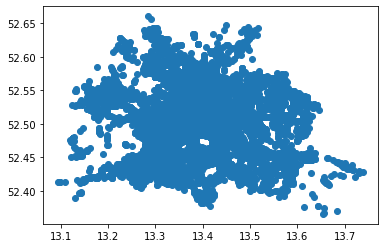

In [4]:
plt.scatter(x=df['XGCSWGS84'], y= df['YGCSWGS84'])

<AxesSubplot:xlabel='LINREFX', ylabel='Count'>

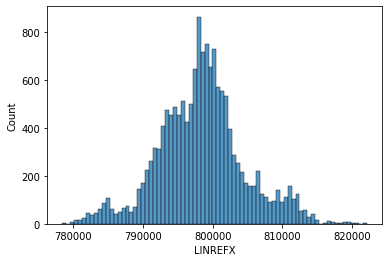

In [5]:
sns.histplot(x = df['LINREFX'])

<AxesSubplot:xlabel='LINREFY', ylabel='Count'>

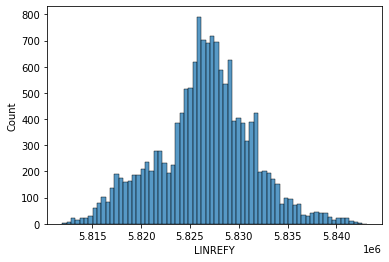

In [6]:
sns.histplot(x = df['LINREFY'])

In [8]:
#need to scale! instantiating scaler
scaler = StandardScaler()

In [10]:
scaler.fit(df[['XGCSWGS84']])

StandardScaler()

In [11]:
df['XGCSWGS84'] = scaler.transform(df[['XGCSWGS84']])

In [12]:
scaler2 = StandardScaler()

In [13]:
scaler2.fit(df[['YGCSWGS84']])

StandardScaler()

In [14]:
df['YGCSWGS84'] = scaler2.transform(df[['YGCSWGS84']])

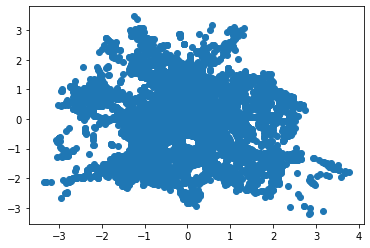

In [15]:
plt.scatter(x=df['XGCSWGS84'], y= df['YGCSWGS84'])

## K-Means

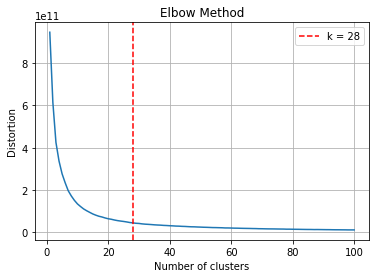

CPU times: user 38min 23s, sys: 11min 50s, total: 50min 13s
Wall time: 3min 26s


In [19]:
%%time
# elbow method for number of clusters

X = df[["LINREFX","LINREFY"]]
max_k = 100

## iterations
distortions = [] 
for i in range(1, max_k+1):
    if len(X) >= i:
        model= KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
        model.fit(X)
        distortions.append(model.inertia_)

## best k: the lowest derivative
k = [i*100 for i in np.diff(distortions,2)].index(min([i*100 for i in np.diff(distortions,2)]))

## plot
fig, ax = plt.subplots()
ax.plot(range(1, len(distortions)+1), distortions)
ax.axvline(k, ls='--', color="red", label="k = "+str(k))
ax.set(title='Elbow Method', xlabel='Number of clusters', 
       ylabel="Distortion")
ax.legend()
ax.grid(True)
plt.show()

In [34]:
%%time

k = 2000
model = KMeans(n_clusters=k, init='k-means++')
X = df[["LINREFX","LINREFY"]]

## clustering
df_X = X.copy()
df_X["cluster"] = model.fit_predict(X)

## find centroids (the datapoints closest to the center)
closest, distances = scipy.cluster.vq.vq(model.cluster_centers_, 
                     df_X.drop("cluster", axis=1).values)
df_X["centroids"] = 0
for i in closest:
    df_X["centroids"].iloc[i] = 1
    
## add clustering info to the original dataset
df[["cluster_km","centroids_km"]] = df_X[["cluster","centroids"]]
df.sample(5)

<timed exec>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


CPU times: user 3min 11s, sys: 6min 5s, total: 9min 16s
Wall time: 51.9 s


,district,LOR,street,LOR_2021,year,month,hour,weekday,category,accident_kind,...,motorcycle,goods_vehicle,others,road_condition,LINREFX,LINREFY,XGCSWGS84,YGCSWGS84,cluster,centroids
14136,4,4030621.0,NaN,4300620.0,2020,9,9,2,3,5,...,0,0,0,0,794161.8034,5827014.911,-0.682955,0.147425,904,0
4776,8,8010301.0,Reuterkiez,8100311.0,2018,11,18,1,3,1,...,0,0,0,1,800544.5736,5824451.258,0.327587,-0.454157,1238,0
9062,1,1011204.0,Leipziger Straße,1100207.0,2019,9,9,4,3,5,...,0,0,0,0,798557.1436,5826814.789,0.028571,0.052407,1006,0
13971,7,7030301.0,NaN,7300516.0,2020,9,18,5,3,1,...,0,0,0,0,794160.6886,5821892.047,-0.733103,-0.896731,629,0
12062,7,7010102.0,NaN,7100102.0,2020,5,18,3,3,2,...,0,0,0,0,794998.7962,5825087.574,-0.565943,-0.255685,743,0


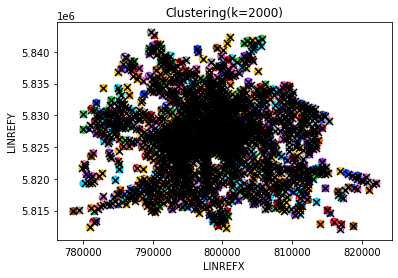

In [35]:
## plot
fig, ax = plt.subplots()
sns.scatterplot(x="LINREFX", y="LINREFY", data=df, 
                palette=sns.color_palette("bright",k),
                hue='cluster', size="centroids", size_order=[1,0],
                legend=False, ax=ax).set_title('Clustering(k='+str(k)+')')
                                                 
th_centroids = model.cluster_centers_
ax.scatter(th_centroids[:,0], th_centroids[:,1], s=50, c='black', 
           marker="x")

In [37]:
# df that contains only centroids for mappinig

df_kmeans_cluster = df[df['centroids'] == 1]

df_kmeans_cluster.head()

,district,LOR,street,LOR_2021,year,month,hour,weekday,category,accident_kind,...,motorcycle,goods_vehicle,others,road_condition,LINREFX,LINREFY,XGCSWGS84,YGCSWGS84,cluster,centroids
8,3,3061434.0,Anton-Saefkow-Park,3601451.0,2018,1,8,2,3,6,...,0,0,0,0,800637.4113,5829909.787,0.397126,0.657119,174,1
10,2,2040701.0,Andreasviertel,2400521.0,2018,1,8,5,2,5,...,0,0,0,1,800966.4920,5827868.971,0.430162,0.237079,414,1
13,7,7030303.0,Grazer Platz,7300619.0,2018,1,16,5,2,5,...,0,0,0,1,795573.4390,5823307.799,-0.490132,-0.625508,1137,1
14,7,7050502.0,Fritz-Werner-Straße ...,7501133.0,2018,1,10,4,2,5,...,0,0,0,1,797451.0135,5817860.220,-0.239183,-1.758983,1949,1
15,1,1011303.0,Alexanderplatzviertel,1100310.0,2018,1,6,3,3,5,...,0,0,0,0,799651.4973,5828438.163,0.222351,0.369546,1621,1


## Affinity propagation

In [40]:
%%time

model = AffinityPropagation()
X = df[["LINREFX","LINREFY"]]

## clustering
df_X = X.copy()
df_X["cluster"] = model.fit_predict(X)

## find real centroids
closest, distances = scipy.cluster.vq.vq(model.cluster_centers_, 
                     df_X.drop("cluster", axis=1).values)
df_X["centroids"] = 0
for i in closest:
    df_X["centroids"].iloc[i] = 1
    
## add clustering info to the original dataset
df[["cluster_ap","centroids_ap"]] = df_X[["cluster","centroids"]]
df.sample(5)

CPU times: user 10min 14s, sys: 30.1 s, total: 10min 44s
Wall time: 10min 17s


/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/sklearn/cluster/_affinity_propagation.py:250: ConvergenceWarning: Affinity propagation did not converge, this model will not have any cluster centers.
  warnings.warn(


,district,LOR,street,LOR_2021,year,month,hour,weekday,category,accident_kind,...,motorcycle,goods_vehicle,others,road_condition,LINREFX,LINREFY,XGCSWGS84,YGCSWGS84,cluster,centroids
10703,7,7020203.0,NaN,7200411.0,2020,2,18,1,3,0,...,0,0,0,1,795922.7651,5824392.642,-0.422826,-0.408698,-1,0
3794,3,3050923.0,Weißenseer Spitze,3500934.0,2018,9,14,3,2,0,...,0,0,0,0,801038.8484,5831666.100,0.479907,1.010007,-1,0
1840,8,8010118.0,Silbersteinstraße,8100105.0,2018,5,20,6,3,6,...,0,0,0,0,800948.6060,5822291.745,0.371600,-0.899324,-1,0
6859,2,2050601.0,Hausburgviertel,2500726.0,2019,5,7,5,3,5,...,0,0,1,1,801865.7288,5828983.034,0.587302,0.452806,-1,0
14924,1,1022204.0,NaN,1200626.0,2020,11,13,5,3,0,...,1,0,0,0,794999.4754,5828142.247,-0.535920,0.366913,-1,0


In [43]:
#model = AffinityPropagation()

In [50]:
#model, dtf_X = fit_ml_cluster(X=df[["XGCSWGS84","YGCSWGS84"]], model=model, figsize=(10,5))

In [49]:
'''
## plot
fig, ax = plt.subplots()
sns.scatterplot(x="LINREFX", y="LINREFY", data=df, 
                palette=sns.color_palette("bright",k),
                hue='cluster', size="centroids", size_order=[1,0],
                legend=False, ax=ax).set_title('Clustering(k='+str(k)+')')
                                                 
th_centroids = model.cluster_centers_
ax.scatter(th_centroids[:,0], th_centroids[:,1], s=50, c='black', 
           marker="x")
''';

## DBSCAN

In [53]:
# find clusters using DB_SCAN (density based)




## SOMs

In [ ]:
# find clusters using SOMs (self organizing maps)

X = df[["XGCSWGS84","YGCSWGS84"]]
map_shape = (4,4)


model = minisom.MiniSom(x=map_shape[0], y=map_shape[1], 
                        input_len=X.shape[1])
model.train_batch(X, num_iteration=100, verbose=1)

## build output dataframe
dtf_X = X.copy()
dtf_X["cluster"] = np.ravel_multi_index(np.array(
      [model.winner(x) for x in X_preprocessed]).T, dims=map_shape)## find real centroids
cluster_centers = np.array([vec for center in model.get_weights() 
                            for vec in center])closest, distances = scipy.cluster.vq.vq(model.cluster_centers_, 
                                         X_preprocessed)
dtf_X["centroids"] = 0
for i in closest:
    dtf_X["centroids"].iloc[i] = 1## add clustering info to the original dataset
dtf[["cluster","centroids"]] = dtf_X[["cluster","centroids"]]## plot
k = dtf["cluster"].nunique()fig, ax = plt.subplots()
sns.scatterplot(x="Latitude", y="Longitude", data=dtf, 
                palette=sns.color_palette("bright",k),
                hue='cluster', size="centroids", size_order=[1,0],
                legend="brief", ax=ax).set_title('Clustering 
                (k='+str(k)+')')th_centroids = scaler.inverse_transform(cluster_centers)
ax.scatter(th_centroids[:,0], th_centroids[:,1], s=50, c='black', 
           marker="x")